In [1]:
import pandas as pd
import scanpy as sc
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from adjustText import adjust_text
from scipy.stats import pearsonr
import os
import re


In [2]:
import random
import numpy as np

random.seed(42)         
np.random.seed(42)      
sc.settings.seed = 42  

In [3]:
out_dir = "output"
os.makedirs(out_dir, exist_ok=True)

In [4]:
adata_pt = sc.read_h5ad("/data/projects/robin/segmentation/xenium_outs/adata_polygon_reduced_pseudotime_X26updated_with_quadrants_with_clusters.h5ad")
adata_pt

AnnData object with n_obs × n_vars = 782 × 480
    obs: 'Disease', 'dpt_pseudotime', 'quadrant', 'Sample_ID', 'KMeans_cluster'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'Disease_colors', 'KMeans_cluster_colors', 'diffmap_evals', 'draw_graph', 'hvg', 'iroot', 'log1p', 'neighbors', 'pca'
    obsm: 'X_diffmap', 'X_draw_graph_fr', 'X_pca'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

In [5]:
adata_pt.obs

,Disease,dpt_pseudotime,quadrant,Sample_ID,KMeans_cluster
polygon_flags,,,,,
0_0011216_ANCA_X17,ANCA,0.444406,1,X17,C3
0_0011216_ANCA_X18,ANCA,0.598062,2,X18,C4
0_0011216_ANCA_X19,ANCA,0.620515,2,X19,C4
0_0011216_ANCA_X20,ANCA,0.416691,1,X20,C3
0_0011216_GBM_X21,GBM,0.833587,3,X21,C4
...,...,...,...,...,...
9_0011762_Cntrl_X1,Cntrl,0.105040,0,X1,C2
9_0018775_ANCA_X58,ANCA,0.479633,2,X58,C3
9_0018775_ANCA_X60,ANCA,0.326151,1,X60,C2


In [6]:
## Defining Cluster_1 and Cluster_234 glom status
adata_pt.obs['glom_status'] = adata_pt.obs['KMeans_cluster'].map(lambda x: 'Cluster_234' if x in ['C2', 'C3', 'C4'] else ('Cluster_1' if x == 'C1' else 'Other'))

In [7]:
# 1. Run DE analysis
sc.tl.rank_genes_groups(adata_pt, groupby='glom_status', groups=['Cluster_234'], reference = 'Cluster_1',method='wilcoxon', key_added='Cluster234_vs_Cluster1')
de_results=sc.get.rank_genes_groups_df(adata_pt,group='Cluster_234',key='Cluster234_vs_Cluster1' )

de_results

/home/zsultana/.local/lib/python3.9/site-packages/numpy/core/fromnumeric.py:84: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
/home/zsultana/.local/lib/python3.9/site-packages/scanpy/get/get.py:69: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  d = d.stack(level=1).reset_index()


,names,scores,logfoldchanges,pvals,pvals_adj
0,LUM,18.239716,2.845680,2.497586e-74,3.996137e-72
1,LAPTM5,17.683493,2.971661,5.620502e-70,5.170894e-68
2,SOD2,17.522032,1.629658,9.728889e-69,6.671238e-67
3,TIMP1,17.241629,3.198906,1.293404e-66,7.760425e-65
4,C1QB,17.229349,2.724710,1.599388e-66,8.530068e-65
...,...,...,...,...,...
475,ATF3,-16.726274,-2.471907,8.435142e-63,2.699245e-61
476,NOD1,-17.675611,-1.057786,6.463617e-70,5.170894e-68
477,EGFL7,-17.869511,-1.998644,2.037753e-71,2.445304e-69
478,NR4A1,-18.257858,-3.029931,1.791827e-74,3.996137e-72


In [8]:
# 2. Select top up and downregulated genes
de_results_filtered = de_results[de_results['pvals_adj'] < 0.05]
up_genes = de_results_filtered.sort_values('logfoldchanges', ascending=False).head(15)
down_genes = de_results_filtered.sort_values('logfoldchanges', ascending=True).head(15)
label_genes = pd.concat([up_genes, down_genes])
label_genes

,names,scores,logfoldchanges,pvals,pvals_adj
3,TIMP1,17.241629,3.198906,1.293404e-66,7.760425e-65
31,C3,13.994093,3.013644,1.693762e-44,1.806679e-43
1,LAPTM5,17.683493,2.971661,5.620502e-70,5.170894e-68
0,LUM,18.239716,2.845680,2.497586e-74,3.996137e-72
4,C1QB,17.229349,2.724710,1.599388e-66,8.530068e-65
95,MZB1,10.093019,2.569213,5.931693e-24,2.093539e-23
7,C1QC,16.939785,2.568472,2.289635e-64,9.158542e-63
62,FN1,11.918383,2.509788,9.493343e-33,5.298610e-32
43,CD79A,12.703326,2.426331,5.666904e-37,4.387281e-36
61,SLPI,11.971897,2.385156,4.987481e-33,2.849989e-32


Looks like you are using a tranform that doesn't support FancyArrowPatch, using ax.annotate instead. The arrows might strike through texts. Increasing shrinkA in arrowprops might help.


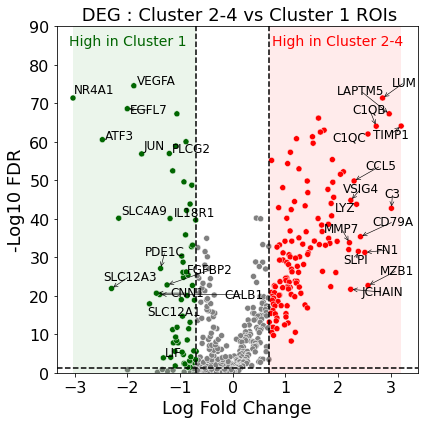

In [9]:

# === Parameters ===
logfc_thresh = 0.69
pval_thresh = 0.05

title_fz=18
xlabel_fz=18
ylabel_fz=18
tick_fontsize = 16  # Tick label size
genelabel_fz=12
HeadingAnnot_fz=14

# === Prepare values ===
xvals = de_results['logfoldchanges']
yvals = -np.log10(de_results['pvals_adj'] + 1e-300)
sig_mask = (de_results['pvals_adj'] < pval_thresh) & (abs(xvals) > logfc_thresh)

 
# Define point colors explicitly
point_colors = np.where(
    (de_results['pvals_adj'] < pval_thresh) & (xvals > logfc_thresh), 'red',
    np.where((de_results['pvals_adj'] < pval_thresh) & (xvals < -logfc_thresh), 'darkgreen', 'grey')
)

# === Plot ===
plt.figure(figsize=(6, 6))
ax = sns.scatterplot(
    x=xvals,
    y=yvals,
    hue=point_colors,
    palette={'red': 'red', 'darkgreen': 'darkgreen', 'grey': 'grey'},
    legend=False
)

# === Draw significance lines ===
plt.axhline(-np.log10(pval_thresh), linestyle='--', color='black')
plt.axvline(logfc_thresh, linestyle='--', color='black')
plt.axvline(-logfc_thresh, linestyle='--', color='black')

# === Background highlights ===
ax.axvspan(logfc_thresh, xvals.max(), ymin=0, ymax=1, facecolor='red', alpha=0.08)
ax.axvspan(xvals.min(), -logfc_thresh, ymin=0, ymax=1, facecolor='green', alpha=0.08)

# === Label DE genes ===
texts = []
for _, row in label_genes.iterrows():
    x = row['logfoldchanges']
    y = -np.log10(row['pvals_adj'] + 1e-300)
    text = plt.text(x, y, row['names'], fontsize=genelabel_fz)
    texts.append(text)

adjust_text(
    texts,
    expand_points=(1.2, 1.4),
    expand_text=(1.2, 1.4),
    arrowprops=dict(arrowstyle="->", color='black', lw=0.6),
    force_points=0.5,
    force_text=0.99
)

# === Axis formatting ===
plt.xlabel("Log Fold Change", fontsize=xlabel_fz)
plt.ylabel("-Log10 FDR", fontsize=ylabel_fz)
plt.xticks(fontsize=tick_fontsize)
plt.yticks(fontsize=tick_fontsize)
plt.title(" DEG : Cluster 2-4 vs Cluster 1 ROIs", fontsize=title_fz)
plt.ylim(0, 90)

# === Annotations for high expression ===
plt.annotate(
    "High in Cluster 1",
    xy=(-2, 85),
    xytext=(-2, 85),
    fontsize=HeadingAnnot_fz,
    ha='center',
    color='darkgreen'
)

plt.annotate(
    "High in Cluster 2-4",
    xy=(2, 85),
    xytext=(2, 85),
    fontsize=HeadingAnnot_fz,
    ha='center',
    color='red'
)

# === Save and show ===
plt.tight_layout()
plt.savefig(os.path.join(out_dir, 'Volcano_Cluster_234vsCluster_1_Highlighted.pdf'))
plt.show()


In [10]:
# samples to plot
samples_to_plot = ['X1', 'X29','X44','X50','X52']

In [11]:
import os
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

def plot_gene_expression_stripplot(df_plot, title_str, out_dir="./output"):
    """
    Plots a strip plot of gene expression per sample across clusters and saves the figure as a PDF.

    Parameters:
        df_plot (pd.DataFrame): DataFrame with columns ['Sample_ID', 'Expression', 'Gene', 'Cluster'].
        title_str (str): String to use in the plot title and output filename.
        out_dir (str): Directory where the output PDF will be saved.
    """
    # Ensure Sample_ID is ordered categorical
    samples_to_plot = sorted(df_plot['Sample_ID'].unique())
    df_plot['Sample_ID'] = pd.Categorical(df_plot['Sample_ID'], categories=samples_to_plot, ordered=True)

    # Define color map and cluster order
    #color_map = {'C1': '#9bcfe6', 'C2': '#007bba', 'C3': '#d7f2c5', 'C4': '#00a300'}
    color_map = {'C1': '#0173B2', 'C2': '#DE8F05', 'C3': '#029E73', 'C4': '#D55E00'}

    cluster_order = ['C1', 'C2', 'C3', 'C4']
    df_plot['Cluster'] = pd.Categorical(df_plot['Cluster'], categories=cluster_order, ordered=True)

    # Font sizes
    xtick_fontsize = 12
    ytick_fontsize = 12
    title_fontsize = 14
    suptitle_fontsize = 16

    # Set up the FacetGrid
    g = sns.FacetGrid(
        df_plot,
        col='Gene',
        hue='Cluster',
        palette=color_map,
        col_wrap=5,
        sharey=False,
        height=3,
        aspect=0.9
    )

    # Strip plot 
    g.map_dataframe(
        sns.stripplot,
        x='Sample_ID',
        y='Expression',
        dodge=True,
        jitter=True,
        alpha=0.8,
        #edgecolor='black',
        #linewidth=0.5,
        order=samples_to_plot
    )

    # Customize subplots
    for ax in g.axes.flatten():
        ax.set_xticks(range(len(samples_to_plot)))
        ax.set_xticklabels(samples_to_plot, rotation=90, ha='center', fontsize=xtick_fontsize)
        ax.tick_params(axis='y', labelsize=ytick_fontsize)

    # Axis labels and titles
    g.set_axis_labels("", "Expression")
    g.set_titles(col_template="{col_name}", size=title_fontsize)
    title_spaces = title_str.replace("_", " ")
    g.fig.suptitle(f"Gene expression per sample: {title_spaces} ROIs (glom. + periglom. regions)", fontsize=suptitle_fontsize, y=0.90)

    # Add legend
    g.add_legend(title='Cluster')
    g._legend.set_bbox_to_anchor((0.95, 0.5))
    g._legend.set_loc("center left")
    g._legend.set_frame_on(True)

    # Adjust layout
    plt.tight_layout(rect=[0, 0, 0.96, 0.95])

    # Save output
    os.makedirs(out_dir, exist_ok=True)
    safe_title = title_str.replace(" ", "_").replace("/", "-")  # make filename safe
    output_path = os.path.join(out_dir, f"gene_expression_stripplot_{safe_title}.pdf")
    plt.savefig(output_path, format='pdf', bbox_inches='tight')

    plt.show()


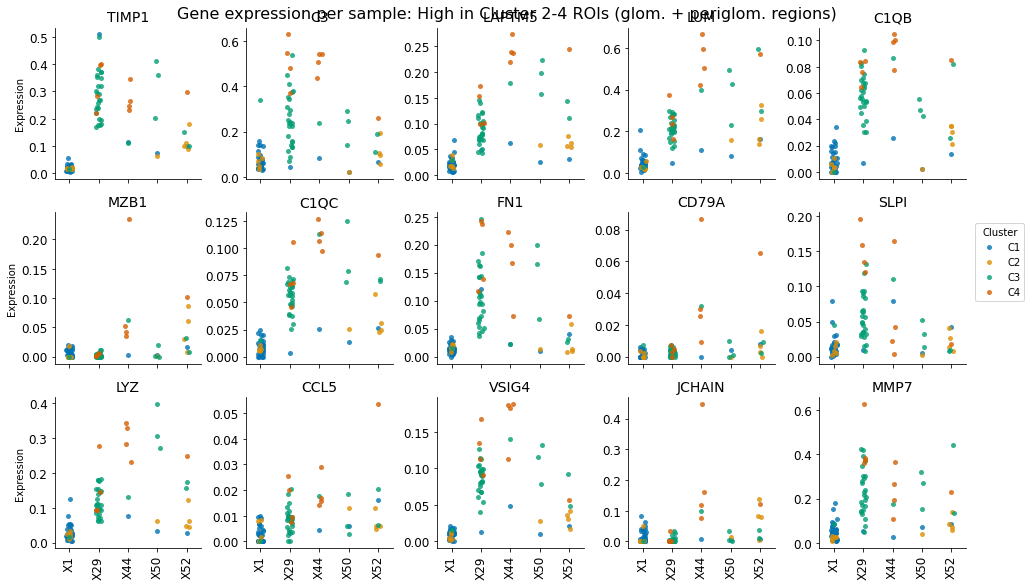

In [12]:
genes_to_plot = up_genes.names

# Build tidy dataframe
plot_data = []
for gene in genes_to_plot:
    expr = adata_pt[:, gene].X.toarray().flatten() if hasattr(adata_pt[:, gene].X, "toarray") else adata_pt[:, gene].X.flatten()
    for i, gid in enumerate(adata_pt.obs_names):
        sample_id = adata_pt.obs.loc[gid, 'Sample_ID']
        cluster = adata_pt.obs.loc[gid, 'KMeans_cluster']
        if sample_id in samples_to_plot:
            plot_data.append({
                'Gene': gene,
                'Expression': expr[i],
                'Sample_ID': sample_id,
                'Cluster': cluster
            })

df_up_genes = pd.DataFrame(plot_data)
df_up_genes
plot_gene_expression_stripplot(df_up_genes,'High in Cluster 2-4')

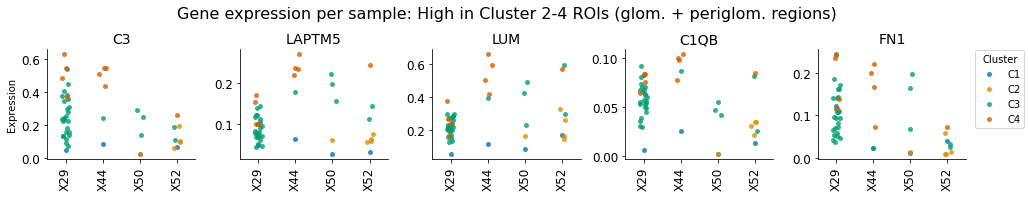

In [13]:
# samples to plot
samples_to_plot = ['X29','X44','X50','X52']
genes_to_plot = ['C3','LAPTM5','LUM','C1QB','FN1']

# Build tidy dataframe
plot_data = []
for gene in genes_to_plot:
    expr = adata_pt[:, gene].X.toarray().flatten() if hasattr(adata_pt[:, gene].X, "toarray") else adata_pt[:, gene].X.flatten()
    for i, gid in enumerate(adata_pt.obs_names):
        sample_id = adata_pt.obs.loc[gid, 'Sample_ID']
        cluster = adata_pt.obs.loc[gid, 'KMeans_cluster']
        if sample_id in samples_to_plot:
            plot_data.append({
                'Gene': gene,
                'Expression': expr[i],
                'Sample_ID': sample_id,
                'Cluster': cluster
            })

df_down_genes = pd.DataFrame(plot_data)
df_down_genes
plot_gene_expression_stripplot(df_down_genes,'High in Cluster 2-4')

In [14]:
df_up_genes

,Gene,Expression,Sample_ID,Cluster
0,TIMP1,0.344429,X44,C4
1,TIMP1,0.074264,X50,C1
2,TIMP1,0.099494,X52,C3
3,TIMP1,0.240724,X29,C3
4,TIMP1,0.007723,X1,C1
...,...,...,...,...
1270,MMP7,0.152847,X1,C1
1271,MMP7,0.302258,X29,C3
1272,MMP7,0.020020,X1,C1
1273,MMP7,0.130105,X29,C3


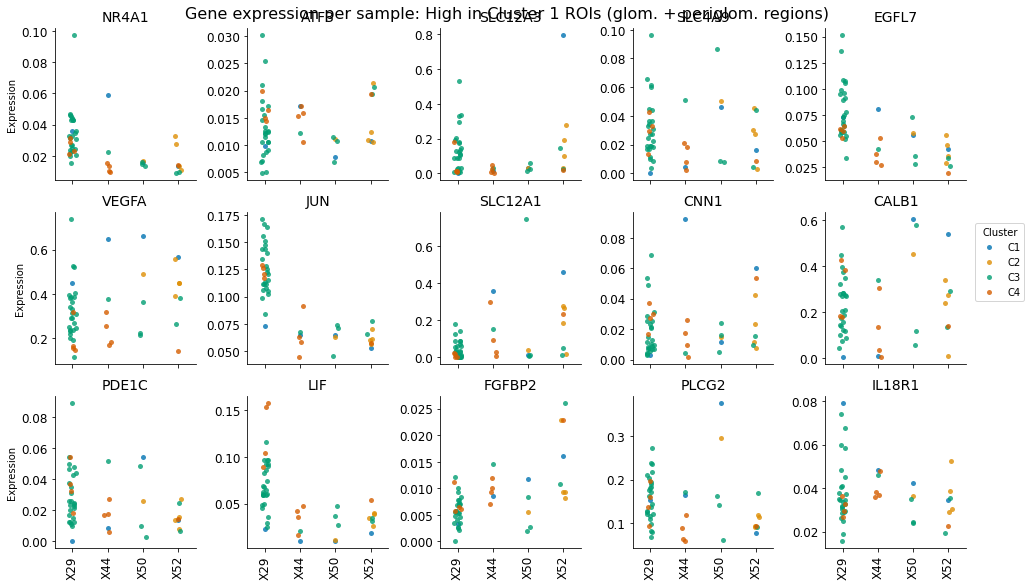

In [14]:
genes_to_plot = down_genes.names

# Build tidy dataframe
plot_data = []
for gene in genes_to_plot:
    expr = adata_pt[:, gene].X.toarray().flatten() if hasattr(adata_pt[:, gene].X, "toarray") else adata_pt[:, gene].X.flatten()
    for i, gid in enumerate(adata_pt.obs_names):
        sample_id = adata_pt.obs.loc[gid, 'Sample_ID']
        cluster = adata_pt.obs.loc[gid, 'KMeans_cluster']
        if sample_id in samples_to_plot:
            plot_data.append({
                'Gene': gene,
                'Expression': expr[i],
                'Sample_ID': sample_id,
                'Cluster': cluster
            })

df_down_genes = pd.DataFrame(plot_data)
df_down_genes
plot_gene_expression_stripplot(df_down_genes,'High in Cluster_1')

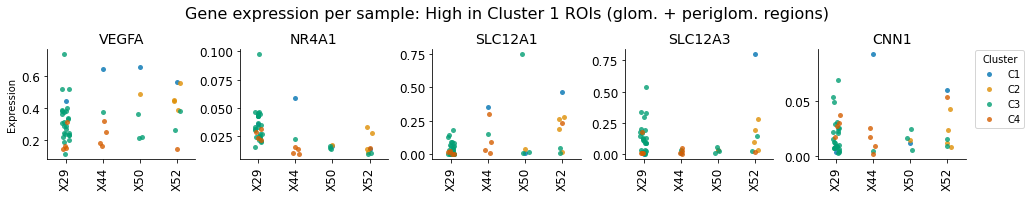

In [15]:
# samples to plot
samples_to_plot = ['X29','X44','X50','X52']
genes_to_plot = ['VEGFA', 'NR4A1','SLC12A1','SLC12A3',  'CNN1']

# Build tidy dataframe
plot_data = []
for gene in genes_to_plot:
    expr = adata_pt[:, gene].X.toarray().flatten() if hasattr(adata_pt[:, gene].X, "toarray") else adata_pt[:, gene].X.flatten()
    for i, gid in enumerate(adata_pt.obs_names):
        sample_id = adata_pt.obs.loc[gid, 'Sample_ID']
        cluster = adata_pt.obs.loc[gid, 'KMeans_cluster']
        if sample_id in samples_to_plot:
            plot_data.append({
                'Gene': gene,
                'Expression': expr[i],
                'Sample_ID': sample_id,
                'Cluster': cluster
            })

df_up_genes = pd.DataFrame(plot_data)
df_up_genes
plot_gene_expression_stripplot(df_up_genes,'High in Cluster_1')